## Fit the models

In [1]:
from imp import reload

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from label import create_label
from basic_set import get_basic
from insensitive_set import get_spread_midprice, get_price_diff, get_mean, get_accumulated_diff
from sensitive_set import get_derivatives
from sampling import sampling_labels, general_sampling
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RF

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
plt.style.use("ggplot")

### Load data

In [89]:
data_raw = pd.read_csv('../data/AAPL_LOB.csv')

### Transform the data

In [90]:
def transform_data_tinsen(data_raw):
    spreads_mids = get_spread_midprice(data_raw)
    price_diff = get_price_diff(data_raw)
    means = get_mean(data_raw)
    accum_diff = get_accumulated_diff(data_raw)
    data_tfm = pd.merge(spreads_mids, price_diff, on = ['Index', 'Time'])
    data_tfm = pd.merge(data_tfm, means, on = ['Index', 'Time'])
    data_tfm = pd.merge(data_tfm, accum_diff, on = ['Index', 'Time'])
    return(data_tfm)

In [91]:
def transform_data(data_raw, feature_basic = True, feature_tinsen = True, feature_tsen = True, delta_t = 30):
    if feature_basic * feature_tinsen * feature_tsen:
        basics = get_basic(data_raw)
        data_tinsen = transform_data_tinsen(data_raw)
        data_tsen = get_derivatives(data_raw, delta_t)
        basics = basics.iloc[delta_t:]
        data_tinsen = data_tinsen.iloc[delta_t:]
        #print("basics_ind:" + str(basics.index[:5]) + "tinsen: "+ str(data_tinsen.index[:5]) + str(data_tsen.index[:5]))
        data_tfm = pd.merge(basics, data_tinsen, on = ['Index', 'Time'])
        data_tfm = pd.merge(data_tfm, data_tsen, on = ['Index', 'Time'])
        return(data_tfm)
    elif (feature_basic == True) and (feature_tinsen == True):
        basics = get_basic(data_raw)
        data_tinsen = transform_data_tinsen(data_raw)
        data_tfm = pd.merge(basics, data_tinsen, on = ['Index', 'Time'])
        return(data_tfm)
    elif (feature_basic == True):
        basics = get_basic(data_raw)
        return(basics)

In [92]:
def split_rawdata(data_raw, split_time = datetime(2012, 5, 22, 11, 0)):
    time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_raw['Time']])
    train_index = time < datetime(2012, 5, 22, 11, 0)
    train = data_raw.iloc[train_index]
    test = data_raw.iloc[ np.logical_and(np.logical_not(train_index),time <= datetime(2012, 5, 22, 12, 0))]
    return({"train": train, "test": test})

In [93]:
raw_data_sets = split_rawdata(data_raw)
train = raw_data_sets["train"]
test = raw_data_sets["test"]

In [94]:
train.shape

(203349, 62)

In [95]:
train_tfm = transform_data(train, delta_t = 30)
test_tfm = transform_data(test, delta_t = 30)

In [96]:
#test_tfm.head()
test_tfm.shape

(76277, 128)

## Prepare y labels

In [98]:
y_lab_train_all = create_label(train_tfm, 30)
y_lab_train_all.shape

(203289, 130)

In [99]:
test_all = create_label(test_tfm, 30)

In [100]:
test_all.shape

(76247, 130)

In [17]:
y_lab_train_all.spread_label.value_counts()

stationary    141221
down            1775
up              1232
dtype: int64

In [18]:
y_lab_train_all.mid_label.value_counts()

down          57521
up            52611
stationary    34096
dtype: int64

In [101]:
index = np.arange(y_lab_train_all.shape[0])
np.random.seed(9)
# Shuffle the index and separate the data into train(50%), validation(25%), and test(25%) set.
np.random.shuffle(index)

# approximate subset
train_x = train_tfm.iloc[index[0:101659]]
validation_x = train_tfm.iloc[index[101659:152489]]
test_x = train_tfm.iloc[index[152489:]]

train_y = y_lab_train_all.iloc[index[0:101659]]
validation_y = y_lab_train_all.iloc[index[101659:152489]]
test_y = y_lab_train_all.iloc[index[152489:]]


In [102]:
print(train_x.shape)
print(validation_x.shape)
print(test_x.shape)
print(train_y.shape)
print(validation_y.shape)
print(test_y.shape)

(101659, 130)
(50830, 130)
(50800, 130)
(101659, 130)
(50830, 130)
(50800, 130)


In [21]:
def cal_measure(CM):
    '''
    input: 3 by 3 confusion matrix
    output: data frame of measurements
    '''
    # for Up (0)
    up = np.array([[CM[0,0],(CM[0,1]+CM[0,2])],[(CM[1,0]+CM[2,0]),(CM[1,1]+CM[2,2]+CM[1,2]+CM[2,1])]], dtype='float')
    station = np.array([[CM[1,1],(CM[1,0]+CM[1,2])],[(CM[0,1]+CM[2,1]),(CM[0,0]+CM[2,2]+CM[0,2]+CM[2,0])]], dtype='float')
    down = np.array([[CM[2,2],(CM[2,0]+CM[2,1])],[(CM[0,2]+CM[1,2]),(CM[0,0]+CM[1,1]+CM[0,1]+CM[1,0])]], dtype='float')
    p_up = up[0,0]/(up[0,0]+up[1,0])
    p_station = station[0,0]/(station[0,0]+station[1,0])
    p_down = down[0,0]/(down[0,0]+down[1,0])
    r_up = up[0,0]/(up[0,0]+up[0,1])
    r_station = station[0,0]/(station[0,0]+station[0,1])
    r_down = down[0,0]/(down[0,0]+down[0,1])
    f_up = 2*p_up*r_up/(p_up+r_up)
    f_station = 2*p_station*r_station/(p_station+r_station)
    f_down = 2*p_down*r_down/(p_down+r_down)
    measure=pd.DataFrame(index=['Up','Stationary','Down'])
    measure['Precision'] = [p_up,p_station,p_down]
    measure['Recall'] = [r_up,r_station,r_down]
    measure['F1_Measure'] = [f_up,f_station,f_down]
    return measure

### Mid-Price Based Model Fitting

Sample from the training set and validation set.

In [22]:
train_sample = general_sampling(train_x, 10000, mid=True, sample_random=True)
valid_sample = general_sampling(validation_x, 10000, mid=True, sample_random=True)

In [23]:
train_sample.mid_label.value_counts()

down          3928
up            3658
stationary    2414
dtype: int64

In [24]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.mid_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['mid_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['mid_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [25]:
valid_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in valid_accmat]

In [26]:
train_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in train_accmat]

In [27]:
valid_accmat

[            Precision    Recall  F1_Measure
 Up           0.694103  0.440377    0.538867
 Stationary   0.028631  0.734043    0.055112
 Down         0.471545  0.462889    0.467177,
             Precision    Recall  F1_Measure
 Up           0.673846  0.446104    0.536820
 Stationary   0.023651  0.826087    0.045986
 Down         0.512195  0.467822    0.489004,
             Precision    Recall  F1_Measure
 Up           0.670769  0.449639    0.538382
 Stationary   0.026971  0.730337    0.052021
 Down         0.517344  0.466406    0.490556,
             Precision    Recall  F1_Measure
 Up           0.677179  0.451762    0.541966
 Stationary   0.024481  0.686047    0.047276
 Down         0.518970  0.470747    0.493684,
             Precision    Recall  F1_Measure
 Up           0.675385  0.449642    0.539865
 Stationary   0.024896  0.714286    0.048115
 Down         0.515447  0.468704    0.490965,
             Precision    Recall  F1_Measure
 Up           0.671282  0.503268    0.575258
 Stat

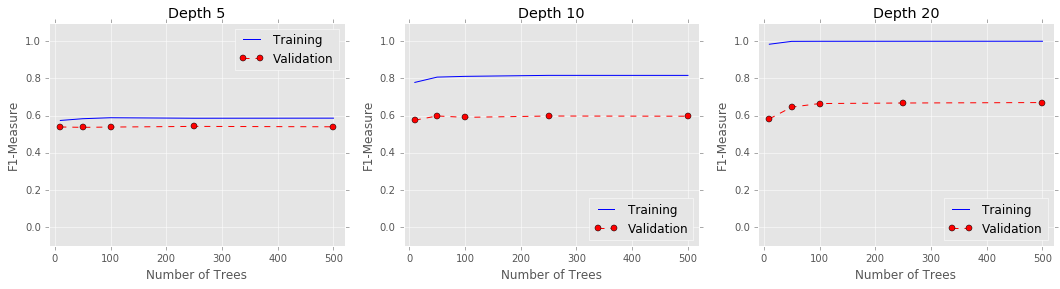

In [28]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_up_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_up_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

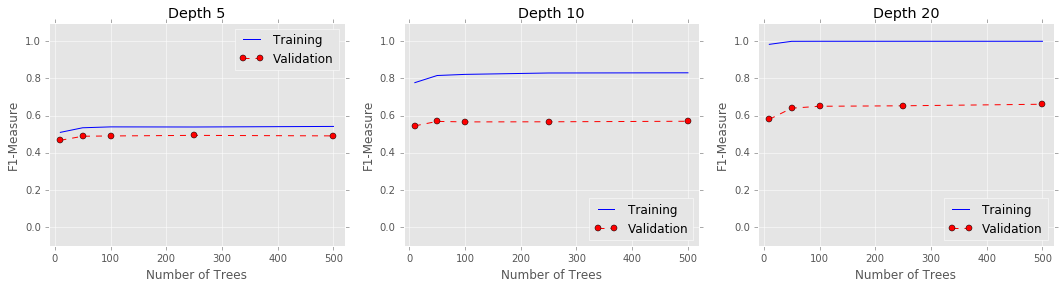

In [29]:
# Down
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_down_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_down_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

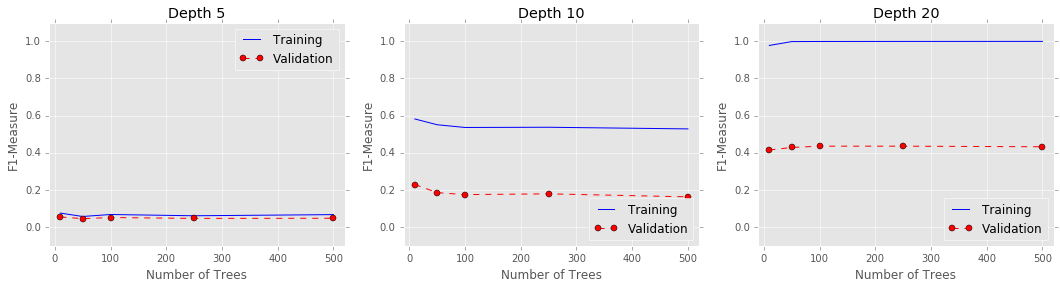

In [30]:
# Stationary
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

In [31]:
first_x = train_tfm.iloc[index[0:110000]]
test_x = train_tfm.iloc[index[110000:]]
train_sample = general_sampling(first_x, 20000, mid=True, sample_random=True)

In [32]:
first_x.shape

(110000, 130)

In [33]:
cand = RF(n_estimators=500, max_depth=20, max_features='sqrt')
cand = cand.fit(first_x[first_x.columns[2:-2]], first_x.mid_label)
predict = cand.predict(test_x[test_x.columns[2:-2]])
CM = confusion_matrix(predict, test_x['mid_label'])

In [350]:
#cand = RF(n_estimators=500, max_depth=20, max_features='sqrt')
#cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.mid_label)
#predict = cand.predict(test_x[test_x.columns[2:-2]])
#CM_1 = confusion_matrix(predict, test_x['mid_label'])

In [34]:
CM

array([[12727,  1322,   626],
       [  388,  5670,   396],
       [  538,  1028, 11533]])

In [35]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.932176,0.867257,0.898546
Stationary,0.706983,0.878525,0.783474
Down,0.918598,0.880449,0.899119


In [356]:
fea_imp = cand.feature_importances_

In [357]:
sorted(fea_imp, reverse=True)

[0.017290959491840875,
 0.015778208332209796,
 0.01507552825747947,
 0.014150560488286085,
 0.013797454806573087,
 0.013369390209936332,
 0.013159575354872633,
 0.012280462710187829,
 0.01207946218392489,
 0.011784949298842395,
 0.011628232392451634,
 0.011603778667247438,
 0.011237638650735286,
 0.011116966704480476,
 0.010878521114173459,
 0.010864970728579369,
 0.010638790621687344,
 0.010037150822084825,
 0.0099229568932033534,
 0.0097469657690285715,
 0.0096585043135393959,
 0.0095757594918642382,
 0.0095566657624432914,
 0.0093621479215764448,
 0.0092980973749949014,
 0.0090727480762425421,
 0.0090661649144584983,
 0.0090244733578068795,
 0.0088171535994552956,
 0.0088066089408514042,
 0.0087948164735735419,
 0.0087698795393591177,
 0.0087625018128972137,
 0.0086773947962617611,
 0.008612655926923684,
 0.0086075360168483099,
 0.0085688713825790505,
 0.0085309540650785609,
 0.0084359596541123925,
 0.0084058655225172606,
 0.0083976081126516909,
 0.0083403845897303801,
 0.0083170988

In [358]:
first_x.columns[2:-2][np.argsort(fea_imp)[::-1]][:20]

Index(['ask_size1', 'size_accumulated_diff', 'mean_ask_vol', 'mean_bid_vol',
       'bid-ask_spread1', 'bid_size1', 'ask_size_derivative1',
       'bid_size_derivative1', 'ask_price_derivative1', 'bid_diff',
       'bid_price_derivative1', 'ask_diff', 'bid_abs2_1',
       'price_accumulated_diff', 'bid_price_derivative2', 'bid-ask_spread2',
       'ask_abs2_1', 'ask_price_derivative2', 'ask_size2', 'ask_size3'],
      dtype='object')

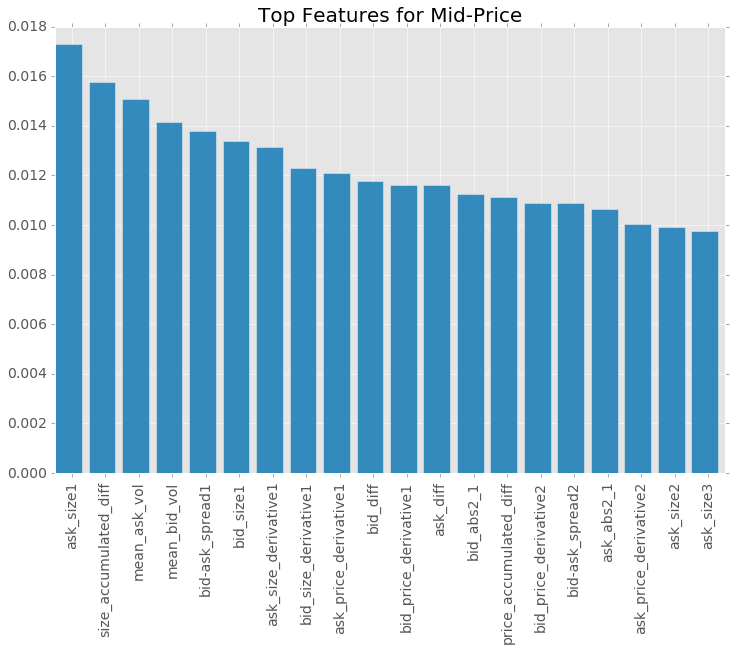

In [359]:
y=sorted(fea_imp, reverse=True)[:20]
x=range(20)
top_fea = list(first_x.columns[2:-2][np.argsort(fea_imp)[::-1]][:20])
plt.figure(figsize = (12, 8))
plt.bar(x,y)
xx=np.arange(20)+0.5
plt.xticks(xx, top_fea, rotation='vertical')
plt.tick_params(labelsize=14)
plt.title("Top Features for Mid-Price", fontsize=20)
plt.show()

In [360]:
#cand = RF(n_estimators=250, max_depth=18, max_features='sqrt')
#cand = cand.fit(train_sample[top_fea], train_sample.mid_label)
#predict = cand.predict(test_x[top_fea])
#CM = confusion_matrix(predict, test_x['mid_label'])

In [363]:
cand_1 = RF(n_estimators=250, max_depth=18, max_features='sqrt')
cand_1 = cand_1.fit(first_x[top_fea], first_x.mid_label)
predict = cand_1.predict(test_x[top_fea])
CM_1 = confusion_matrix(predict, test_x['mid_label'])

In [364]:
CM_1

array([[17998,  2278,  1417],
       [  452,  8621,   497],
       [ 1167,  1793, 16577]])

In [365]:
cal_measure(CM_1)

,Precision,Recall,F1_Measure
Up,0.917470,0.829669,0.871363
Stationary,0.679247,0.900836,0.774504
Down,0.896490,0.848493,0.871831


### Spread-Crossing Based Model Fitting

Sample from the training and validation set.

In [103]:
train_x.shape

(101659, 130)

In [104]:
train_sample = general_sampling(train_x, 10000, mid=False, up_prob=0.1,down_prob=0.1)
valid_sample = general_sampling(validation_x, 10000, mid=False, sample_random=True)

In [36]:
train_sample = general_sampling(train_x, 10000, mid=False, sample_random=True)
valid_sample = general_sampling(validation_x, 10000, mid=False, sample_random=True)

In [125]:
train_sample.columns[-2:]

Index(['mid_label', 'spread_label'], dtype='object')

In [105]:
train_sample.spread_label.value_counts()

stationary    8000
up            1000
down          1000
dtype: int64

#### Random Forest

In [106]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['spread_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['spread_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [107]:
valid_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in valid_accmat]

In [108]:
train_up_f1 = [pd.ix['Up']['F1_Measure'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['F1_Measure'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['F1_Measure'] for pd in train_accmat]

In [30]:
v=valid_accmat

In [138]:
#valid_accmat

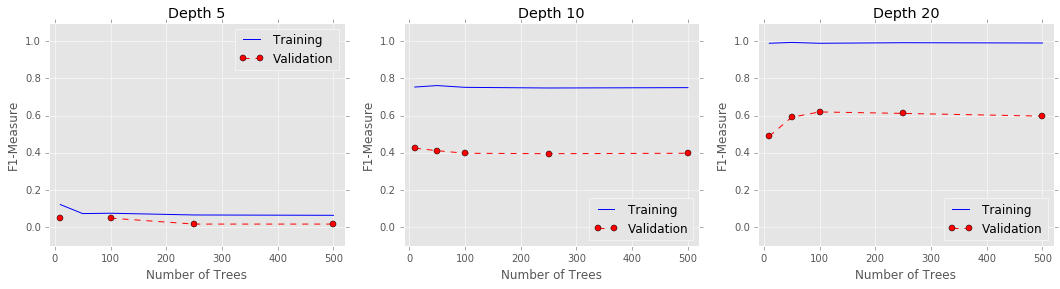

In [111]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_up_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_up_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

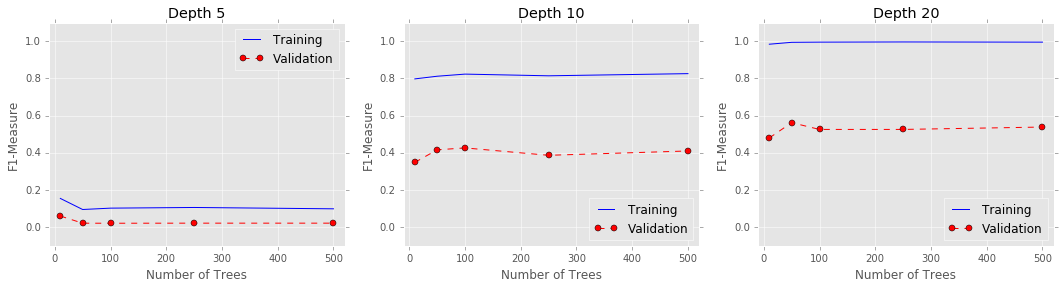

In [112]:
# Down
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_down_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_down_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

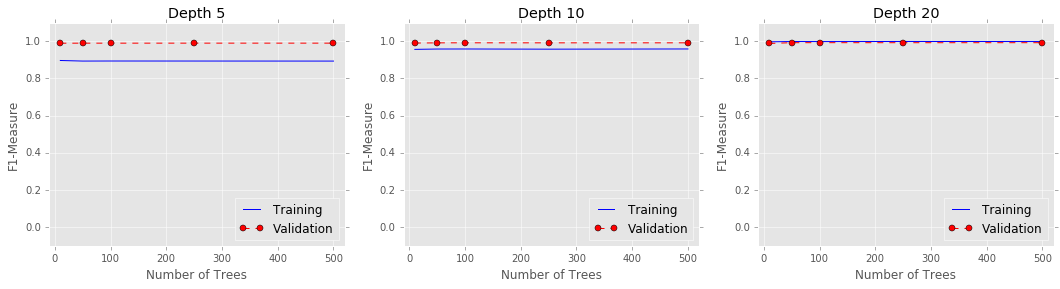

In [113]:
# Stationary
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18, 4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    axis.legend(loc=4)
plt.show()

In [114]:
first_x = train_tfm.iloc[index[0:152489]]
first_x.shape[0]

152489

In [115]:
first_x = train_tfm.iloc[index[0:152489]]
test_x = train_tfm.iloc[index[152489:]]
train_sample = general_sampling(first_x, first_x.shape[0], mid=False, up_prob=0.1,down_prob=0.1)

In [116]:
cand = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
predict = cand.predict(test_x[test_x.columns[2:-2]])
CM = confusion_matrix(predict, test_x['spread_label'])

In [46]:
cand = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand = cand.fit(first_x[first_x.columns[2:-2]], first_x.spread_label)
predict = cand.predict(test_x[test_x.columns[2:-2]])
CM = confusion_matrix(predict, test_x['spread_label'])

In [117]:
CM

array([[  399,    81,     0],
       [  144, 49663,   134],
       [    0,    82,   297]])

In [118]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.734807,0.831250,0.780059
Stationary,0.996729,0.994433,0.995580
Down,0.689095,0.783641,0.733333


In [119]:
fea_imp = cand.feature_importances_

In [120]:
sorted(fea_imp, reverse=True)

[0.063756938279068351,
 0.040303629056172324,
 0.022547351991918083,
 0.016143657768376587,
 0.01521495284521239,
 0.014720544976306767,
 0.01437773826059237,
 0.013712099464407466,
 0.013667107166948965,
 0.011789613983517385,
 0.011423586098750688,
 0.011090069704350789,
 0.010779195604927246,
 0.010460141298261012,
 0.010448739851697003,
 0.0102947631733187,
 0.010114478075395214,
 0.010085828193471143,
 0.010079523672538428,
 0.0097662309816096624,
 0.0096571092767277732,
 0.009447155819324711,
 0.0094179485115929284,
 0.009283039599667621,
 0.0089301681257737287,
 0.0089104905245187844,
 0.0084243060305334953,
 0.0082876680637846093,
 0.008282131869401483,
 0.0081988597014283175,
 0.0081108214932850854,
 0.008105262743761589,
 0.0080808930403133711,
 0.0079376127765360509,
 0.0079184729312460032,
 0.0078312403966308234,
 0.0078067369569777513,
 0.0077755150720787824,
 0.0077647322943677245,
 0.0075824461798121388,
 0.0075290523384944361,
 0.0074636292566666674,
 0.0074540479607393

In [121]:
train_sample.columns[2:-2][np.argsort(fea_imp)[::-1]][:20]

Index(['bid-ask_spread1', 'bid-ask_spread2', 'bid-ask_spread3',
       'price_accumulated_diff', 'mean_ask_vol', 'ask_diff', 'bid_diff',
       'bid-ask_spread4', 'size_accumulated_diff', 'ask_size_derivative1',
       'mean_bid_vol', 'bid-ask_spread5', 'ask_price_derivative1', 'ask_size2',
       'bid_abs2_1', 'ask_abs2_1', 'ask_size5', 'bid-ask_spread6',
       'bid-ask_spread9', 'bid_size6'],
      dtype='object')

In [178]:
#top_fea

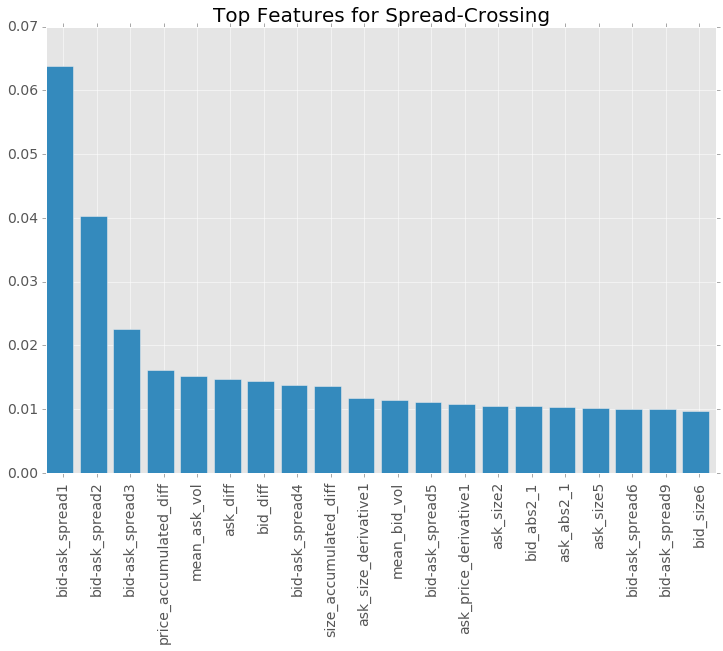

In [122]:
y=sorted(fea_imp, reverse=True)[:20]
x=range(20)
top_fea = list(train_sample.columns[2:-2][np.argsort(fea_imp)[::-1]][:20])
plt.figure(figsize = (12, 8))
plt.bar(x,y)
xx=np.arange(20)+0.5
plt.xticks(xx, top_fea, rotation='vertical')
plt.tick_params(labelsize=14)
plt.title("Top Features for Spread-Crossing", fontsize=20)
plt.show()

In [124]:
cand = RF(n_estimators=100, max_depth=18, max_features='sqrt')
cand = cand.fit(train_sample[top_fea], train_sample.spread_label)
predict = cand.predict(test_x[top_fea])
CM = confusion_matrix(predict, test_x['spread_label'])

In [69]:
cand = RF(n_estimators=100, max_depth=18, max_features='sqrt')
cand = cand.fit(first_x[top_fea], first_x.spread_label)
predict = cand.predict(test_x[top_fea])
CM = confusion_matrix(predict, test_x['spread_label'])

In [70]:
CM

array([[16886,   404,    53],
       [  476, 16550,   517],
       [   17,   277, 13680]])

In [71]:
cal_measure(CM)

,Precision,Recall,F1_Measure
Up,0.971632,0.973649,0.972640
Stationary,0.960478,0.943396,0.951861
Down,0.960000,0.978961,0.969388


In [431]:
predict = cand.predict(test_all[top_fea])
CM_1 = confusion_matrix(predict, test_all['spread_label'])

In [432]:
CM_1

array([[    0,     0,     0],
       [  349, 75573,   325],
       [    0,     0,     0]])

***split data again to 10:30 and 11:00***

In [172]:
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_raw['Time']])
before_11 = data_raw.iloc[time < datetime(2012, 5, 22, 11, 0)]
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in before_11['Time']])
before_11 = before_11.iloc[time >= datetime(2012, 5, 22, 10, 30)]

In [175]:
before_11.shape
#test_all.shape

(59061, 62)

In [176]:
before_11_tfm = transform_data(before_11, delta_t = 30)

In [177]:
before_11_tfm.shape

(59031, 128)

In [178]:
before_11_x = create_label(before_11_tfm, 30)
before_11_x.shape

(59001, 130)

In [179]:
before_11_x.spread_label.value_counts()

stationary    58244
up              388
down            369
dtype: int64

In [188]:
train_sample = general_sampling(before_11_x, 10000, mid=False, up_prob=0.1,down_prob=0.1)
valid_sample = general_sampling(before_11_x, 10000, mid=False, sample_random=True)

In [189]:
train_accmat = []
valid_accmat = []
for d in [5,10,20]:
    for n in [10,50,100,250,500]:
        cand = RF(n_estimators=n, max_depth=d, max_features='sqrt')
        cand = cand.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
        predict_train = cand.predict(train_sample[train_sample.columns[2:-2]])
        CM_train = confusion_matrix(predict_train, train_sample['spread_label'])
        predict_valid = cand.predict(valid_sample[valid_sample.columns[2:-2]])
        CM_valid = confusion_matrix(predict_valid, valid_sample['spread_label'])
        train_accmat.append(cal_measure(CM_train))
        valid_accmat.append(cal_measure(CM_valid))
        print((n,d))

(10, 5)
(50, 5)
(100, 5)
(250, 5)
(500, 5)
(10, 10)
(50, 10)
(100, 10)
(250, 10)
(500, 10)
(10, 20)
(50, 20)
(100, 20)
(250, 20)
(500, 20)


In [190]:
valid_up_f1 = [pd.ix['Up']['Recall'] for pd in valid_accmat]
valid_down_f1 = [pd.ix['Down']['Recall'] for pd in valid_accmat]
valid_stat_f1 = [pd.ix['Stationary']['Recall'] for pd in valid_accmat]

In [191]:
train_up_f1 = [pd.ix['Up']['Recall'] for pd in train_accmat]
train_down_f1 = [pd.ix['Down']['Recall'] for pd in train_accmat]
train_stat_f1 = [pd.ix['Stationary']['Recall'] for pd in train_accmat]

In [192]:
valid_accmat

[            Precision    Recall  F1_Measure
 Up           0.479452  0.432099    0.454545
 Stationary   0.992597  0.992396    0.992496
 Down         0.409091  0.482143    0.442623,
             Precision    Recall  F1_Measure
 Up           0.506849  0.637931    0.564885
 Stationary   0.996653  0.992226    0.994435
 Down         0.378788  0.675676    0.485437,
             Precision    Recall  F1_Measure
 Up           0.561644  0.539474    0.550336
 Stationary   0.995538  0.992820    0.994177
 Down         0.378788  0.694444    0.490196,
             Precision    Recall  F1_Measure
 Up           0.520548  0.558824    0.539007
 Stationary   0.996146  0.992322    0.994231
 Down         0.378788  0.757576    0.505051,
             Precision    Recall  F1_Measure
 Up           0.520548  0.584615    0.550725
 Stationary   0.996248  0.992423    0.994332
 Down         0.393939  0.722222    0.509804,
             Precision    Recall  F1_Measure
 Up           0.890411  0.670103    0.764706
 Stat

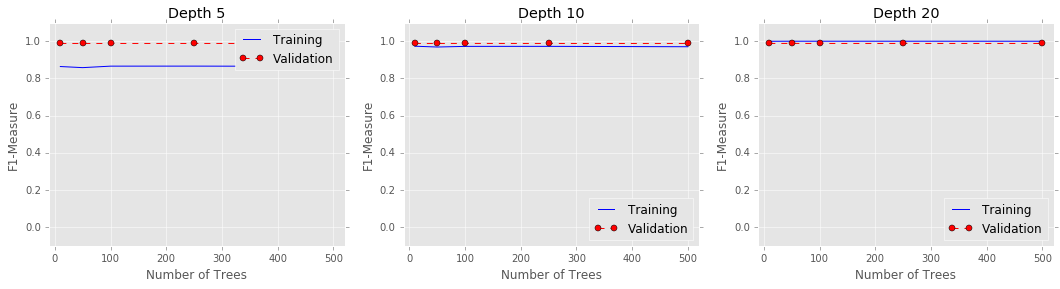

In [528]:
# Up
n = [10,50,100,250,500]
d = [5,10,20]
fig = plt.figure(figsize = (18,4))
for plot_number in range(1,4):
    axis = fig.add_subplot(1, 3, plot_number)
    axis.plot(n, train_stat_f1[(plot_number-1)*5:plot_number*5], color = 'b', label='Training')
    axis.plot(n, valid_stat_f1[(plot_number-1)*5:plot_number*5], marker='o', linestyle='--', color='r', label='Validation')
    axis.set_xlabel('Number of Trees')
    axis.set_ylabel('F1-Measure')
    axis.set_title('Depth ' + str(d[plot_number-1]))
    axis.set_xlim(-10, 520)
    axis.set_ylim(-0.1, 1.1)
    if plot_number == 1:
        axis.legend(loc=1)
    else:
        axis.legend(loc=4)
plt.show()

In [588]:
cand_11 = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand_11 = cand_11.fit(before_11_x[before_11_x.columns[2:-2]], before_11_x.spread_label)
predict = cand_11.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [193]:
train_sample = general_sampling(before_11_x, before_11_x.shape[0], mid=False, up_prob=0.4,down_prob=0.4)
cand_11 = RF(n_estimators=250, max_depth=20, max_features='sqrt')
cand_11 = cand_11.fit(train_sample[train_sample.columns[2:-2]], train_sample.spread_label)
predict = cand_11.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [212]:
predict = cand.predict(test_all[test_all.columns[2:-2]])
CM_11 = confusion_matrix(predict, test_all['spread_label'])

In [83]:
test_all.shape

(76247, 130)

In [213]:
CM_11

array([[    0,     0,     0],
       [  349, 75569,   325],
       [    0,     4,     0]])

In [214]:
cal_measure(CM_11)

,Precision,Recall,F1_Measure
Up,0.000000,NaN,NaN
Stationary,0.999947,0.99116,0.995534
Down,0.000000,0.00000,NaN


In [54]:
predict[-30:]

array(['stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'stationary'], dtype=object)

In [604]:
np.asarray(test_all['spread_label'])

array(['stationary', 'stationary', 'stationary', ..., 'stationary',
       'stationary', 'stationary'], dtype=object)

In [86]:
pro = compute_profit(test_tfm, np.asarray(test_all['spread_label']), 30)

In [61]:
pro = compute_profit(test_tfm, predict, 30)

In [62]:
sum(pro)

0

In [387]:
CM_11

array([[16358, 12918,  8691],
       [ 1112,  1606,   718],
       [10211, 10704, 13929]])

In [388]:
cal_measure(CM_11)

,Precision,Recall,F1_Measure
Up,0.590947,0.430848,0.498355
Stationary,0.063659,0.467404,0.112057
Down,0.596838,0.399753,0.478808


***Calculate Profit***

In [39]:
def compute_profit(test, prediction, delta_t):
    '''
    test: data frame
    prediction: predicted trend using delta_t (np.array) 
    delta_t: float
    '''
    preds = pd.Series(prediction)
    #test.index = range(test.shape[0])
    profit = []
    for i in range(len(prediction)):
        if preds[i] == 'up':
            profit.append(test.bid_price1[i+delta_t] - test.ask_price1[i])
        if preds[i] == 'down':
            profit.append(test.bid_price1[i] - test.ask_price1[i+delta_t])
        if preds[i] == 'stationary':
            profit.append(0)
    return(profit)

In [130]:
pro = compute_profit(test,predict_test,20)

H:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Concat data and draw time series

In [127]:
data_all = pd.concat([train_tfm, test_tfm])

In [128]:
data_all.shape

(279596, 130)

In [129]:
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_all['Time']])

datetime.datetime(2012, 5, 22, 11, 0, 4, 398000)

In [140]:
time[203319]

datetime.datetime(2012, 5, 22, 11, 0, 1, 363000)

In [197]:
data_all.columns

Index(['Index', 'Time', 'ask_price1', 'ask_price2', 'ask_price3', 'ask_price4',
       'ask_price5', 'ask_price6', 'ask_price7', 'ask_price8',
       ...
       'bid_size_derivative3', 'bid_size_derivative4', 'bid_size_derivative5',
       'bid_size_derivative6', 'bid_size_derivative7', 'bid_size_derivative8',
       'bid_size_derivative9', 'bid_size_derivative10', 'mid_label',
       'spread_label'],
      dtype='object', length=130)

In [198]:
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_all['Time']])
fea = ['bid-ask_spread1', 'bid-ask_spread2', 'bid-ask_spread3',
       'price_accumulated_diff', 'mean_ask_vol', 'ask_diff', 'bid_diff',
       'bid-ask_spread4', 'size_accumulated_diff', 'ask_size_derivative1',
       'mean_bid_vol', 'bid-ask_spread5', 'ask_price_derivative1', 'ask_size2',
       'bid_abs2_1', 'ask_abs2_1', 'ask_size5', 'bid-ask_spread6',
       'bid-ask_spread9', 'bid_size6']
#mean_price = (data_raw.ask_price1 + data_raw.bid_price1)/2

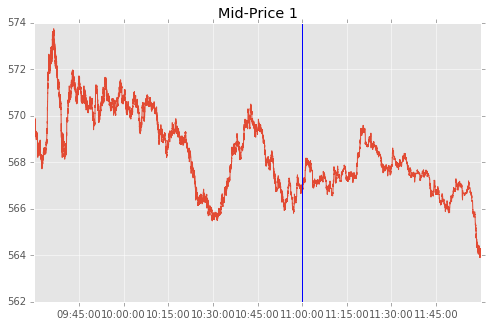

In [221]:
plt.figure(figsize=(8,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all['mid-price_spread1'])
plt.axvline(x=time[203319])
plt.title("Mid-Price 1")

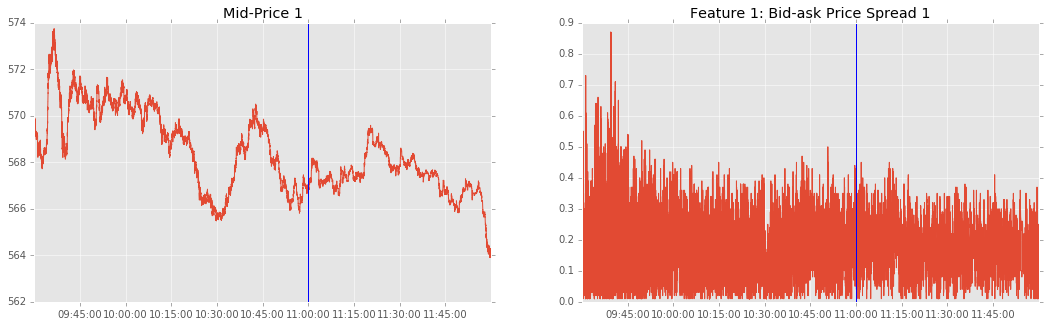

In [228]:
fig = plt.figure(figsize = (18, 5))
axis1 = fig.add_subplot(1, 2, 1)
axis1.plot(time, data_all['mid-price_spread1'])
axis1.axvline(x=time[203319])
axis1.set_title("Mid-Price 1")
axis2 = fig.add_subplot(1, 2, 2)
axis2.plot(time, data_all[fea[0]])
axis2.axvline(x=time[203319])
axis2.set_title("Feature 1: Bid-ask Price Spread 1")

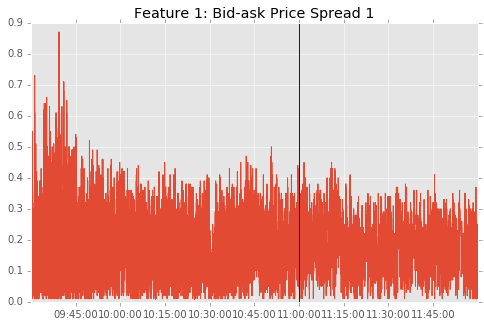

In [222]:
plt.figure(figsize=(8,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[0]])
plt.axvline(x=time[203319])
plt.title("Feature 1: Bid-ask Price Spread 1")

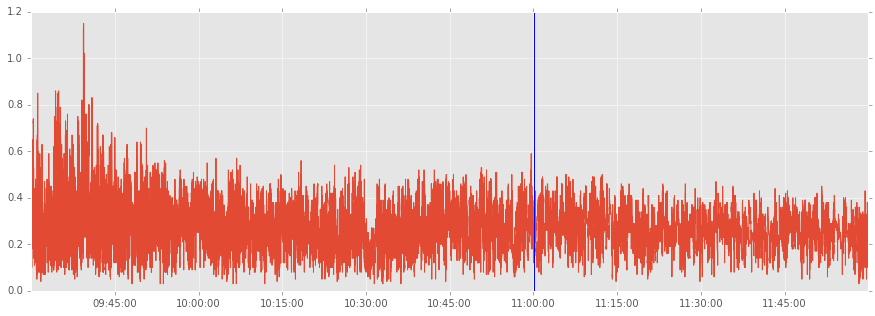

In [200]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[1]])
plt.axvline(x=time[203319])

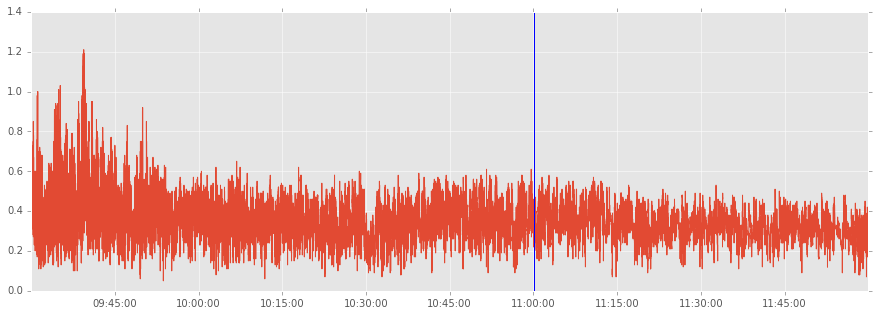

In [201]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[2]])
plt.axvline(x=time[203319])

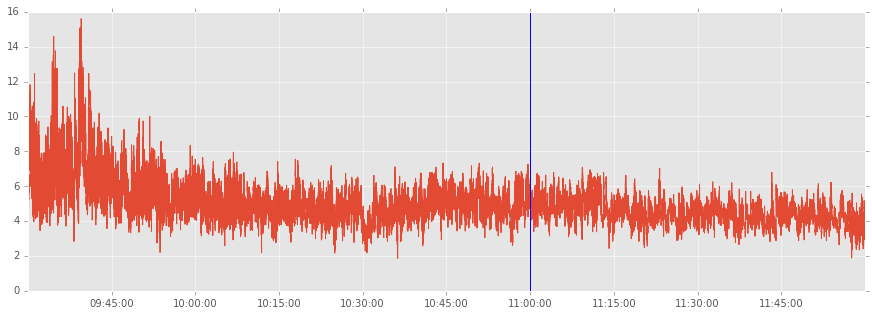

In [202]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[3]])
plt.axvline(x=time[203319])

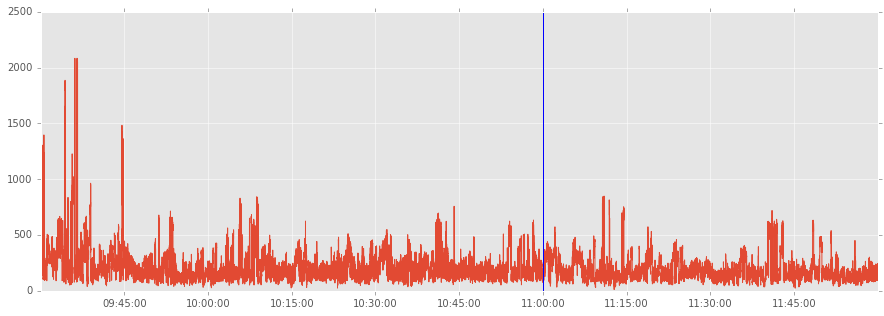

In [203]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[4]])
plt.axvline(x=time[203319])

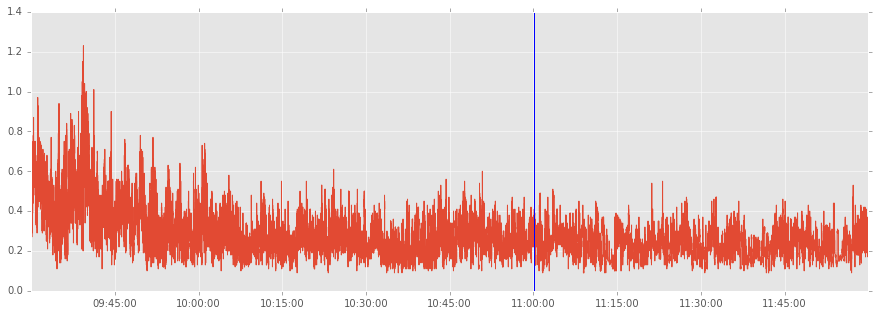

In [204]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[5]])
plt.axvline(x=time[203319])

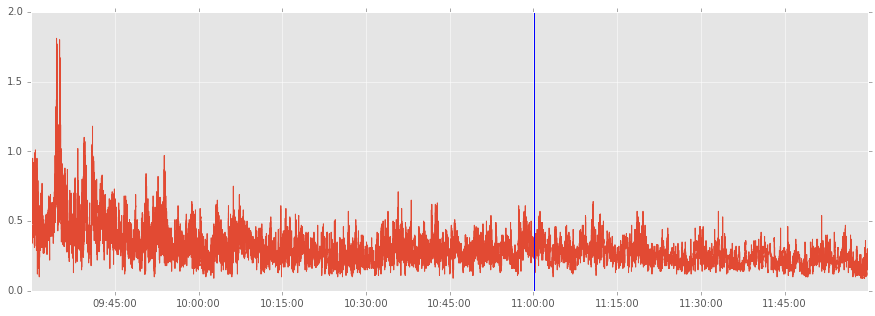

In [205]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[6]])
plt.axvline(x=time[203319])

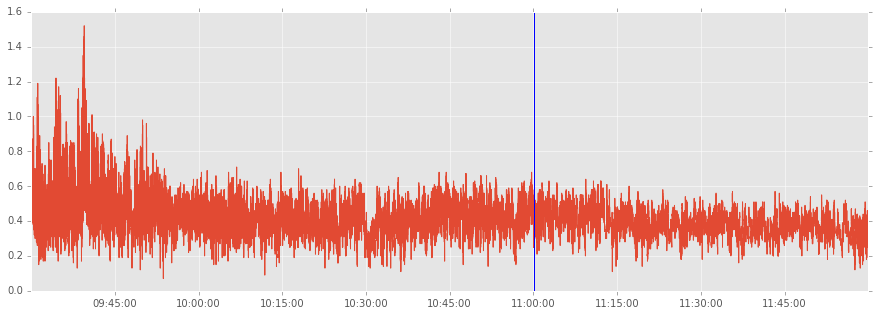

In [206]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[7]])
plt.axvline(x=time[203319])

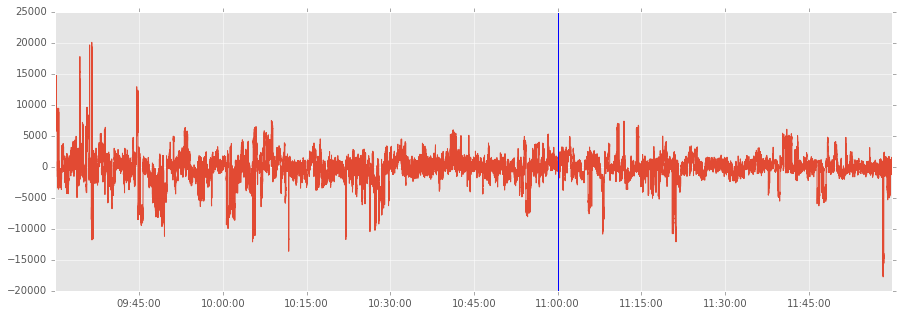

In [207]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[8]])
plt.axvline(x=time[203319])

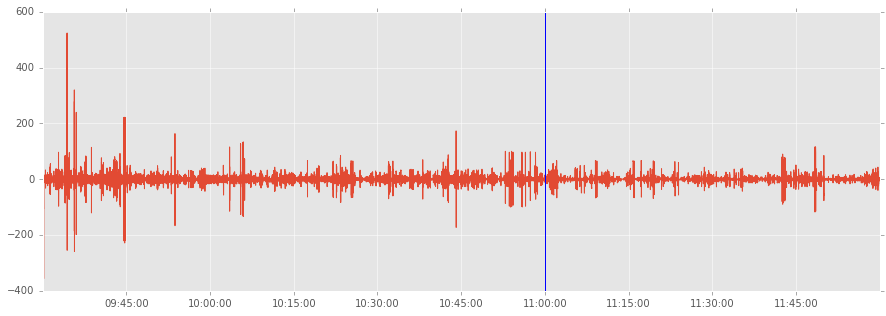

In [208]:
plt.figure(figsize=(15,5))
# plt.plot(time, data_all['mean_ask_vol'])
plt.plot(time, data_all[fea[9]])
plt.axvline(x=time[203319])

In [169]:
train_sum = train_tfm.describe()
test_sum = test_tfm.describe()

In [171]:
print(train_sum[fea[1]])
print(test_sum[fea[1]])

count    203319.000000
mean          0.297919
std           0.103520
min           0.030000
25%           0.230000
50%           0.290000
75%           0.360000
max           1.150000
Name: bid-ask_spread2, dtype: float64
count    76277.000000
mean         0.266731
std          0.074579
min          0.030000
25%          0.220000
50%          0.270000
75%          0.320000
max          0.500000
Name: bid-ask_spread2, dtype: float64


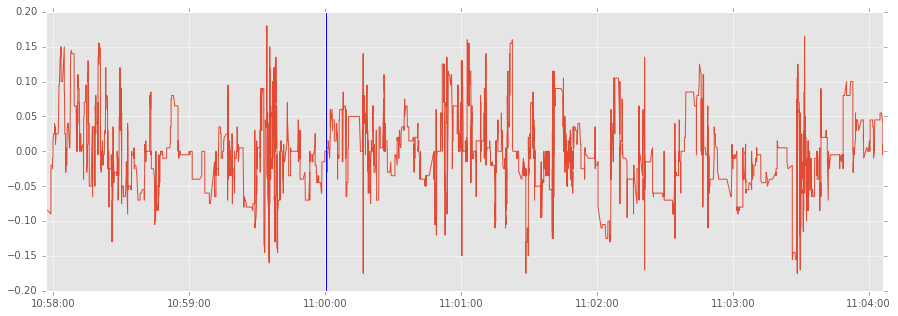

In [54]:
time = np.array([datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in data_raw['Time']])
delta_t = 30
mid_price = (data_raw.ask_price1+data_raw.bid_price1)/2
mid_shift = np.append(mid_price[delta_t:], np.array(np.nan).repeat(delta_t))
price_diff = mid_shift - mid_price
ba_spread = data_raw.ask_price1 - data_raw.bid_price1
plt.figure(figsize=(15,5))
#plt.plot(time[:-delta_t], price_diff[:-delta_t])
#plt.plot(time, ba_spread)
plt.plot(time[200000:210000], price_diff[200000:210000])
plt.axvline(x=time[203349])